# Introduction to JPEG: Practical tools

Martin Beneš

<div style="text-align: center">
<img src="https://www.uibk.ac.at/media/filer_public/00/c3/00c369ba-9e7a-42a4-9f73-466c81dc951a/universitaet-innsbruck-logo-cmyk-farbe.jpg" style="height: 5em; display: inline; padding-right: 2em" />
<img src="https://www.uncoverproject.eu/wp-content/uploads/2021/05/UNCOVER-Logog-440x92.5-final-1.0.png" style="height: 4em; display: inline; padding-left: 2em" />
</div>

## Notebook setup

First, install `jpeglib` package.

In [1]:
!pip install jpeglib  # install dependencies

We use again `00001.tif` from ALASKA database as a sample image.

In [2]:
# download 00001.tif from ALASKA website
import requests
res = requests.get('http://alaska.utt.fr/DATASETS/ALASKA_v2_TIFF_512_COLOR/00001.tif', verify=False)
with open('00001.tif', 'wb') as f:
    f.write(res.content)

/opt/miniconda3/envs/dev/lib/python3.8/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'alaska.utt.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


## In JPEG we can work losslessly with DCT coefficients.

DCT coefficients denote the contribution of each frequency to the pixel block. $8x8$ DCT block denotes following frequencies. These frequencies are also called subbands.

<div style="text-align: center">
<img src="https://github.com/uibk-uncover/prague-jpeg-demo/blob/main/img/dct.png?raw=true" style="height: 25em"/>
</div>

We start with JPEG-compressed file `cover_qf75.jpeg`.

In [3]:
import jpeglib
import numpy as np
from PIL import Image
RGB = np.array(Image.open('00001.tif'))  # load RGB
jpeglib.from_spatial(RGB).write_spatial('cover_qf75.jpeg', qt=75)

We can losslessly read and write DCT coefficients.

In [4]:
jpeg = jpeglib.read_dct('cover_qf75.jpeg')  # read JPEG in DCT domain

The luminance tensor can be accessed with `Y`. Original $512\times512$ image is split into $64\times64$ pixel blocks, each consisting of $8\times8$ pixels (because $\frac{512}{8}=64$).

In [5]:
jpeg.Y.shape

(64, 64, 8, 8)

This is obtain the top-left luminance $8\times8$ block as follows.

In [6]:
jpeg.Y[0, 0]  # top-left block of luminance

array([[-18,  -5,  -6,   0,   0,   0,   0,   0],
       [  4,  -1,   2,  -1,   1,   0,   0,   0],
       [  1,   0,   1,  -1,   0,   0,   0,   0],
       [  3,  -1,  -1,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0]], dtype=int16)

The subbands, e.g. 01, can be acquired by a simple expression.

In [7]:
jpeg.Y[:, :, 0, 1]  # 01 subband of luminance

array([[ -5,   0,  -2, ...,  -2,   6, -17],
       [ -7,   1,   3, ..., -44,  55,   6],
       [-13,   9,  -5, ...,  27,   9,  -4],
       ...,
       [ 48,  -7,   4, ...,   3,  11,  -3],
       [ 35,   3,   6, ...,  11,   1,  -2],
       [ 29,   2,   5, ...,  13,   0,   1]], dtype=int16)

Subband 00 is called DC, all the others are called AC.

## Chrominance is often subsampled.

Get the chrominance (red and blue) with `Cb` and `Cr`.

In [8]:
jpeg.Cb.shape

(32, 32, 8, 8)

In [9]:
jpeg.Cr.shape

(32, 32, 8, 8)

In [10]:
jpeg.Y.shape

(64, 64, 8, 8)

You get the top-left chrominance $8\times8$ block similarly to before.

In [11]:
jpeg.Cb[0, 0]  # top-left block of blue chrominance

array([[-13,  -4,  -2,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [ -1,   2,   0,   0,   0,   0,   0,   0],
       [  0,  -1,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0]], dtype=int16)

The chrominance channels are often subsampled, which further reduces the file size.

The sampling factor can be derived from the shapes, or accessed directly as `samp_factor`.

In [12]:
jpeg.Cb.shape[0] / jpeg.Y.shape[0]

0.5

In [13]:
jpeg.samp_factor  # sampling factors of chrominances

array([[2, 2],
       [1, 1],
       [1, 1]], dtype=int32)

## Quality factor is an abstraction for a quantization table (QT).

The quantization tables can be accessed via the image's `qt` property.

In [14]:
jpeg.qt  # quantization tables at QF75

array([[[ 8,  6,  5,  8, 12, 20, 26, 31],
        [ 6,  6,  7, 10, 13, 29, 30, 28],
        [ 7,  7,  8, 12, 20, 29, 35, 28],
        [ 7,  9, 11, 15, 26, 44, 40, 31],
        [ 9, 11, 19, 28, 34, 55, 52, 39],
        [12, 18, 28, 32, 41, 52, 57, 46],
        [25, 32, 39, 44, 52, 61, 60, 51],
        [36, 46, 48, 49, 56, 50, 52, 50]],

       [[ 9,  9, 12, 24, 50, 50, 50, 50],
        [ 9, 11, 13, 33, 50, 50, 50, 50],
        [12, 13, 28, 50, 50, 50, 50, 50],
        [24, 33, 50, 50, 50, 50, 50, 50],
        [50, 50, 50, 50, 50, 50, 50, 50],
        [50, 50, 50, 50, 50, 50, 50, 50],
        [50, 50, 50, 50, 50, 50, 50, 50],
        [50, 50, 50, 50, 50, 50, 50, 50]]], dtype=uint16)

There are two quantization tables for three components (Y, Cb, Cr). Cb and Cr components can share the same quantization table.

In [15]:
jpeg.qt.shape

(2, 8, 8)

In [16]:
jpeg.quant_tbl_no  # assignment of QTs

array([0, 1, 1])

In some implementations, the quality factor basically scales the quantization table. A high quality factor leads to small-valued quantization tables. A lower quality factor corresponds to more quantization, i.e., higher quantization table entries.

In [17]:
# QT at QF90
jpeglib.from_spatial(RGB).write_spatial('cover_qf90.jpeg', qt=90)
jpeg_q90 = jpeglib.read_dct('cover_qf90.jpeg')
jpeg_q90.qt

array([[[ 3,  2,  2,  3,  5,  8, 10, 12],
        [ 2,  2,  3,  4,  5, 12, 12, 11],
        [ 3,  3,  3,  5,  8, 11, 14, 11],
        [ 3,  3,  4,  6, 10, 17, 16, 12],
        [ 4,  4,  7, 11, 14, 22, 21, 15],
        [ 5,  7, 11, 13, 16, 21, 23, 18],
        [10, 13, 16, 17, 21, 24, 24, 20],
        [14, 18, 19, 20, 22, 20, 21, 20]],

       [[ 3,  4,  5,  9, 20, 20, 20, 20],
        [ 4,  4,  5, 13, 20, 20, 20, 20],
        [ 5,  5, 11, 20, 20, 20, 20, 20],
        [ 9, 13, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20]]], dtype=uint16)

A higher quality factor means the values in quantization become lower.

In [18]:
# QT at QF100
jpeglib.from_spatial(RGB).write_spatial('cover_qf100.jpeg', qt=100)
jpeg_q100 = jpeglib.read_dct('cover_qf100.jpeg')
jpeg_q100.qt

array([[[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]],

       [[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]]], dtype=uint16)

Quality factor 100 correspond to QTs with all ones.

## DCT coefficients follow a Laplace distribution

The distribution of DCT coefficients is symmetric around $0$ and usually follows a Laplace distribution.

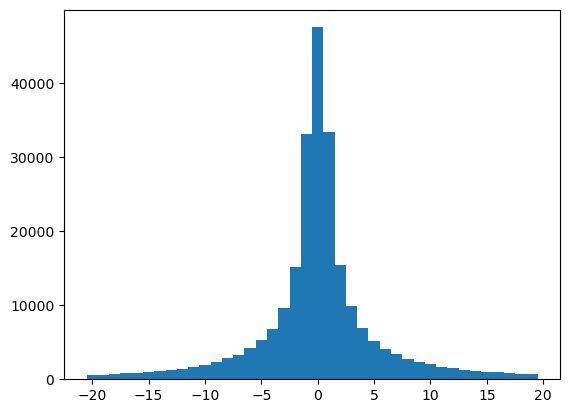

In [19]:
import matplotlib.pyplot as plt
N = 40
plt.hist(jpeg_q100.Y.flatten(), bins=N, range=(-N//2-.5, N//2-.5));

At lower QFs, we observe much more zeros.

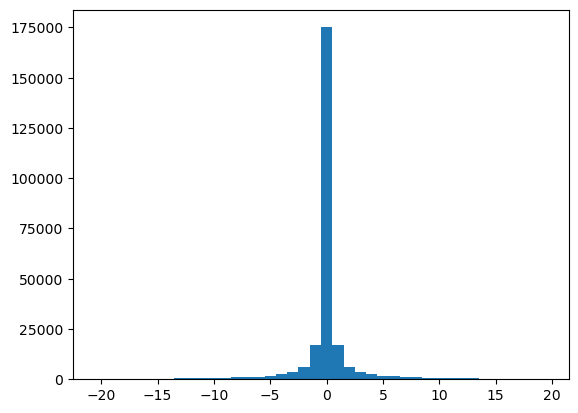

In [20]:
N = 40
plt.hist(jpeg_q90.Y.flatten(), bins=N, range=(-N//2-.5, N//2-.5));

## Hands-on: Double compression

- What can you spot in DCT histogram of a double-compressed image?

<div style="text-align: center">
<img src="https://github.com/uibk-uncover/prague-jpeg-demo/blob/main/img/2_dct_histogram.png?raw=true" style="height: 15em"/>
</div>

### Solution

Double compression with different quality factors leaves comb-like traces.

In [21]:
# compress with JPEG at QF95
jpeglib.from_spatial(RGB).write_spatial('cover_qf95.jpeg', qt=95)
# decompress JPEG
im = jpeglib.read_spatial('cover_qf95.jpeg')
# compress again at QF98
im.write_spatial('cover_qf95_qf98.jpeg', qt=98)

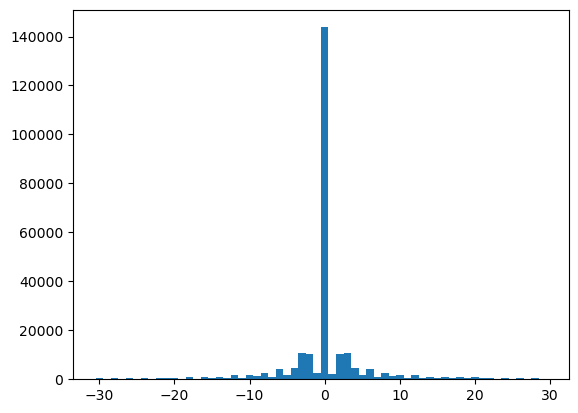

In [22]:
jpeg = jpeglib.read_dct('cover_qf95_qf98.jpeg')
N = 60
plt.hist(jpeg.Y.flatten(), bins=N, range=(-N//2-.5, N//2-.5));

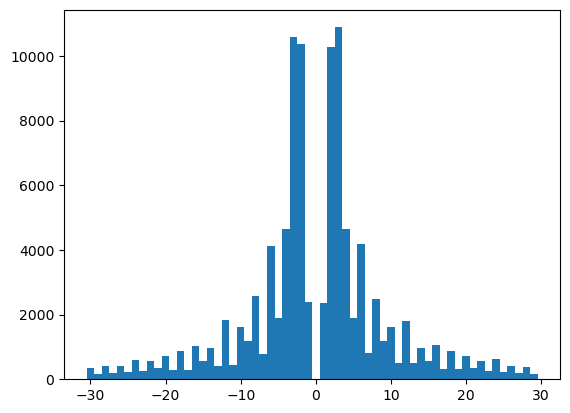

In [23]:
# Removing the zero bin to zoom in closer on the other bins.
plt.hist(jpeg.Y[jpeg.Y != 0].flatten(), bins=N, range=(-N//2-.5, N//2-.5));

## Extension: More features of jpeglib

JPEG have typically YCbCr color space. But it can be also YCCK, or RGB.

In [24]:
jpeg.jpeg_color_space

JCS_YCbCr

The DCT coefficients are compressed losslessly using Huffman-like encoding.

In [25]:
jpeg.huffmans

[{'AC': <Huffman 0,0,2,1,3,...>, 'DC': <Huffman 0,0,1,5,1,...>},
 {'AC': <Huffman 0,0,2,1,2,...>, 'DC': <Huffman 0,0,3,1,1,...>},
 {},
 {}]

JPEG metadata and thumbnail are stored in *markers*.

In [26]:
jpeg.markers

[<Marker JPEG_APP0 N=14>, <Marker JPEG_APP0 N=14>]

Most JPEGs use the *sequential* compression mode. However, JPEGs can also be stored in *progressive* mode.

In [27]:
jpeg.progressive_mode

False

By default, MozJPEG produces progressive JPEGs.

In [28]:
jpeglib.version.set('mozjpeg403')
jpeglib.from_spatial(RGB).write_spatial('cover_moz.jpeg', qt=98)
jpeg_moz = jpeglib.read_spatial('cover_moz.jpeg')

In [29]:
jpeg_moz.progressive_mode

True

Moreover, MozJPEG performs an additional optimization called Trellis optimization, which allows for further reduction of the file size. At the same time, however, Trellis optimization introduces artifacts in the DCT histogram.

In [30]:
jpeg_moz = jpeglib.read_spatial('cover_moz.jpeg', buffered=True)
jpeg_moz.scans # View the individual scans of a progressively-stored JPEG image

[<Scan 0,0,0,0: [0 1 2]>,
 <Scan 1,5,0,3: [0]>,
 <Scan 6,63,0,3: [0]>,
 <Scan 1,63,3,2: [0]>,
 <Scan 1,63,0,2: [1]>,
 <Scan 1,63,0,2: [2]>,
 <Scan 1,63,2,1: [0]>,
 <Scan 1,63,2,1: [1]>,
 <Scan 1,63,2,1: [2]>,
 <Scan 1,63,1,0: [0]>,
 <Scan 1,63,1,0: [1]>,
 <Scan 1,63,1,0: [2]>]

Trellis quantization leaves *vampire-teeth* artifacts in the DCT histogram. The origin of these artifacts is described in [Hofer and Böhme, "Progressive JPEGs in the Wild:
Implications for Information Hiding and Forensics", ACM IH&MMSec 2023](https://informationsecurity.uibk.ac.at/pdfs/HB2023_IHMMSEC.pdf).

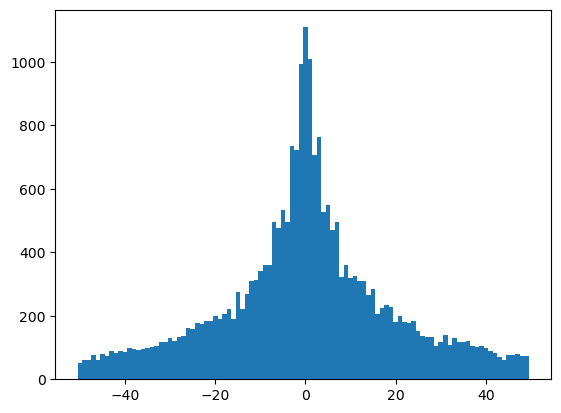

In [31]:
ZIGZAG_ORDER = [
    0, 1, 8, 16, 9, 2, 3, 10, 17, 24, 32, 25, 18, 11, 4, 5,
    12, 19, 26, 33, 40, 48, 41, 34, 27, 20, 13, 6, 7, 14, 21, 28,
    35, 42, 49, 56, 57, 50, 43, 36, 29, 22, 15, 23, 30, 37, 44, 51,
    58, 59, 52, 45, 38, 31, 39, 46, 53, 60, 61, 54, 47, 55, 62, 63,
]
jpegP = jpeglib.read_dct('cover_moz.jpeg')
Y = jpegP.Y.reshape(-1, 64)[..., ZIGZAG_ORDER]
N = 100
plt.hist(Y[:, 1:8].flatten(), bins=N, range=(-N//2-.5, N//2-.5));